In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import os

In [2]:
path = r'/Users/polinarozhkova/Desktop/GitHub/cr_eda_chicago/'

In [3]:
district_shp = os.path.join(path, 'PoliceDistrict', 'PoliceDistrict.shp')
df_district = geopandas.read_file(district_shp)
df_district['DIST_NUM'] = df_district['DIST_NUM'].astype(float)

In [4]:
beat_shp = os.path.join(path, 'Boundaries - Police Beats (current)',
                        'geo_export_7f053540-59bf-4d25-b453-b6f10b77c115.shp')
beat_df = geopandas.read_file(beat_shp)
beat_df['beat_num'] = beat_df['beat_num'].astype(float)

In [5]:
# Additional data: Homicides, Clearance Rates, Racial Demographics
final_merge_df = pd.read_csv(os.path.join(path, 'clean_data/merge_all.csv'))
cr_reports = pd.read_excel(os.path.join(path, 'inputs/CR_from_CPD_Annual_Reports_copy.xlsx'))
beats_race = pd.read_csv(os.path.join(path, 'inputs/beat_estimates.csv'))

In [6]:
# Racial Demographics by Beat
race_2021 = beats_race[beats_race['year'] == 2021].drop(
    columns='Unnamed: 0').reset_index(drop=True)
race_2021['perc_white'] = round((race_2021.white_nothisp/race_2021.tot_pop)*100, 2)
race_2021['perc_black'] = round((race_2021.black_nothisp/race_2021.tot_pop)*100, 2)
race_2021['perc_hisp'] = round((race_2021.tot_hisp/race_2021.tot_pop)*100, 2)

In [7]:
final_merge_df

,case_number,unique_id,date_x,block_x,primary_type,iucr,age,sex,race,month,...,year,id,date,injury_type,cleared,date_clear,beat,district,time_to_clear,year_cleared
0,G011117,HOM-G011117-#1,2001-01-06 03:30:00,8700 S BURLEY AVE,HOMICIDE,110,20-29,M,BLK,1,...,2001,644.0,2001-01-06 00:00:00,SHOT,Y,2001-02-27,424.0,4.0,52.0,2001.0
1,G011288,HOM-G011288-#1,2001-01-06 08:54:00,1700 S ASHLAND AVE,HOMICIDE,110,20-29,M,BLK,1,...,2001,639.0,2001-01-06 00:00:00,SHOT,N,NaN,1222.0,12.0,NaN,NaN
2,G032407,HOM-G032407-#1,2001-01-16 01:17:00,600 N CICERO AVE,HOMICIDE,110,20-29,M,BLK,1,...,2001,659.0,2001-01-16 00:00:00,SHOT,Y,2001-05-28,1111.0,11.0,132.0,2001.0
3,G040822,HOM-G040822-#1,2001-01-20 01:09:00,1000 N CICERO AVE,HOMICIDE,110,0-19,M,BLK,1,...,2001,663.0,2001-01-20 00:00:00,SHOT,Y,2001-01-24,1111.0,11.0,4.0,2001.0
4,G042611,HOM-G042611-#1,2001-01-20 23:26:00,700 N DRAKE AVE,HOMICIDE,110,30-39,M,WWH,1,...,2001,664.0,2001-01-20 00:00:00,SHOT,Y,2001-07-05,1121.0,11.0,166.0,2001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11494,JE258289,HOM-JE258289-#1,2021-06-08 12:58:00,3800 S WELLS ST,HOMICIDE,110,20-29,M,BLK,6,...,2021,25982.0,2021-06-08 12:58:00,SHOT,N,NaN,915.0,9.0,NaN,NaN
11495,JD443510,HOM-JD443510-#1,2020-11-27 20:23:00,3900 W JACKSON BLVD,HOMICIDE,110,20-29,M,BLK,11,...,2020,25639.0,2020-11-27 20:23:00,SHOT,N,NaN,1132.0,11.0,NaN,NaN
11496,HK505802,HOM-HK505802-#1,2004-06-19 12:01:00,6900 S CAMPBELL AVE,HOMICIDE,110,20-29,M,BLK,6,...,2004,2806.0,2004-06-19 00:00:00,SHOT,N,NaN,832.0,8.0,NaN,NaN
11497,JC378474,HOM-JC378474-#2,2019-08-04 17:46:00,5400 S WINCHESTER AVE,HOMICIDE,110,50-59,M,BLK,8,...,2019,24678.0,2019-08-04 17:46:00,SHOT,N,NaN,932.0,9.0,NaN,NaN


In [8]:
def clean(df):
    df = df.rename(columns={'ward_x': 'ward', 'beat': 'beat_num','district': 'DIST_NUM'})
    df['cleared'] = df['cleared'].map({'Y': 1, 'N': 0})
    df['gunshot_injury'] = final_merge_df['gunshot_injury_i'].map({'YES': True, 'NO': False})
    return df

In [9]:
final_merge_df = clean(final_merge_df)

In [10]:
final_merge_df.groupby(['DIST_NUM'])['cleared'].sum().reset_index()

,DIST_NUM,cleared
0,1.0,66
1,2.0,233
2,3.0,349
3,4.0,395
4,5.0,321
5,6.0,365
6,7.0,422
7,8.0,328
8,9.0,313
9,10.0,351


In [11]:
def map_points(df, df_district):
    df_district = df_district.merge(df, on=['DIST_NUM']).reset_index()
    return df_district

In [12]:
def district_grouped(df, df_cleared, df_district):
    hom_district = df.groupby(['DIST_NUM'])['case_number'].count().reset_index()
    hom_district = hom_district.rename(columns={'case_number': 'homicide_count'})
    clear_district = df.groupby(['DIST_NUM'])['cleared'].sum().reset_index()
    hom_district = hom_district.merge(clear_district, on=['DIST_NUM']).reset_index()
    hom_district['dist_cr'] = round((hom_district.cleared/hom_district.homicide_count)*100, 2)
    df_district = df_district.merge(hom_district)
    df_district = df_district.to_crs('EPSG:4326')
    return df_district

In [13]:
def beat_grouped(df, df_cleared, beat_df):
    hom_beat = df.groupby(['beat_num'])['case_number'].count().reset_index()
    hom_beat = hom_beat.rename(columns={'case_number': 'homicide_count'})
    clear_beat = df.groupby(['beat_num'])['cleared'].sum().reset_index()
    hom_beat = hom_beat.merge(clear_beat, on=['beat_num']).reset_index()
    hom_race_merge = pd.merge(hom_beat, race_2021, how="inner", on=['beat_num'])
    hom_beat['beat_cr'] = round((hom_beat.cleared/hom_beat.homicide_count)*100, 2)
    beat_df = beat_df.merge(hom_race_merge, on=['beat_num'])
    beat_df = beat_df.to_crs('EPSG:4326')
    return beat_df

In [14]:
hom_2019 = final_merge_df[final_merge_df['year'] == 2019]
hom_2020 = final_merge_df[final_merge_df['year'] == 2020]
hom_2021 = final_merge_df[final_merge_df['year'] == 2021]

In [15]:
clear_2019 = final_merge_df[final_merge_df['year_cleared'] == 2019]
clear_2020 = final_merge_df[final_merge_df['year_cleared'] == 2020]
clear_2021 = final_merge_df[final_merge_df['year_cleared'] == 2021]

In [16]:
clear_2019

,case_number,unique_id,date_x,block_x,primary_type,iucr,age,sex,race,month,...,id,date,injury_type,cleared,date_clear,beat_num,DIST_NUM,time_to_clear,year_cleared,gunshot_injury
424,HH435955,HOM-HH435955-#1,2002-06-12 07:30:00,4800 N SHERIDAN RD,HOMICIDE,110,40-49,F,BLK,6,...,1539.0,2002-06-12 07:30:00,STRANGULATION,1,2019-09-23,2024.0,20.0,6311.0,2019.0,False
617,HH695279,HOM-HH695279-#1,2002-10-06 01:22:00,0 E GARFIELD BLVD,HOMICIDE,110,30-39,M,BLK,10,...,24684.0,2002-10-06 01:22:00,SHOT,1,2019-11-05,225.0,2.0,6238.0,2019.0,True
1630,HL352987,HOM-HL352987-#1,2005-05-12 23:44:00,10600 S OGLESBY AVE,HOMICIDE,110,20-29,M,BLK,5,...,3478.0,2005-05-12 23:44:00,SHOT,1,2019-03-11,434.0,4.0,5050.0,2019.0,True
1827,HL755239,HOM-HL755239-#1,2005-11-25 17:58:00,4100 W 19TH ST,HOMICIDE,110,20-29,M,BLK,11,...,3426.0,2005-11-25 17:58:00,SHOT,1,2019-12-27,1012.0,10.0,5144.0,2019.0,True
2094,HM552299,HOM-HM552299-#1,2006-08-20 21:16:00,11400 S CALUMET AVE,HOMICIDE,110,20-29,M,BLK,8,...,3749.0,2006-08-20 21:16:00,SHOT,1,2019-12-23,531.0,5.0,4872.0,2019.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,JC443095,HOM-JC443095-#2,2019-09-21 19:13:00,0 E 112TH PL,HOMICIDE,110,40-49,M,BLK,9,...,24758.0,2019-09-21 19:13:00,SHOT,1,2019-12-06,531.0,5.0,75.0,2019.0,True
11361,HY325525,HOM-HY325525-#2,2015-07-03 01:20:00,9100 S ASHLAND AVE,HOMICIDE,110,40-49,M,BLK,7,...,21955.0,2015-07-03 01:20:00,SHOT,1,2019-07-08,2221.0,22.0,1465.0,2019.0,True
11379,JC314445,HOM-JC314445-#2,2019-06-20 14:45:00,5400 W MONROE ST,HOMICIDE,110,30-39,M,BLK,6,...,24611.0,2019-06-20 14:45:00,SHOT,1,2019-12-23,1522.0,15.0,185.0,2019.0,True
11472,JA235987,HOM-JA235987-#2,2017-04-23 13:06:00,9700 S YALE AVE,HOMICIDE,110,20-29,M,BLK,4,...,23254.0,2017-04-23 13:06:00,SHOT,1,2019-12-31,511.0,5.0,981.0,2019.0,True


In [17]:
hom_2019.groupby(['beat_num'])['cleared'].sum().reset_index()

,beat_num,cleared
0,111.0,1
1,114.0,0
2,132.0,1
3,211.0,0
4,212.0,0
...,...,...
172,2531.0,3
173,2532.0,1
174,2533.0,0
175,2534.0,0


In [18]:
hom_2019.groupby(['beat_num'])['case_number'].count().reset_index()

,beat_num,case_number
0,111.0,1
1,114.0,1
2,132.0,1
3,211.0,1
4,212.0,1
...,...,...
172,2531.0,3
173,2532.0,3
174,2533.0,1
175,2534.0,2


In [19]:
number_hom_2019 = map_points(hom_2019, df_district)
number_hom_2020 = map_points(hom_2020, df_district)
number_hom_2021 = map_points(hom_2021, df_district)

In [20]:
number_hom_2019.crs

<Derived Projected CRS: EPSG:3435>
Name: NAD83 / Illinois East (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [21]:
hom_dist_2019 = district_grouped(hom_2019, clear_2019, df_district)
hom_dist_2020 = district_grouped(hom_2020, clear_2020, df_district)
hom_dist_2021 = district_grouped(hom_2021, clear_2021, df_district)

In [22]:
hom_beat_2019 = beat_grouped(hom_2019, clear_2019, beat_df)
hom_beat_2020 = beat_grouped(hom_2020, clear_2020, beat_df)
hom_beat_2021 = beat_grouped(hom_2021, clear_2021, beat_df)

In [23]:
hom_dist_2019.crs

<Derived Projected CRS: EPSG:3435>
Name: NAD83 / Illinois East (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [24]:
hom_dist_2019

,DIST_LABEL,DIST_NUM,geometry,index,homicide_count,cleared,dist_cr
0,18TH,18.0,"POLYGON ((1175460.210 1916490.580, 1175754.304...",16,4,2,50.00
1,11TH,11.0,"POLYGON ((1154811.841 1907804.704, 1154812.073...",10,73,18,24.66
2,15TH,15.0,"POLYGON ((1144144.724 1907554.463, 1144145.853...",13,41,8,19.51
3,12TH,12.0,"POLYGON ((1172733.212 1902927.155, 1172733.662...",11,17,8,47.06
4,24TH,24.0,"POLYGON ((1163335.029 1951662.632, 1165733.989...",19,9,4,44.44
5,16TH,16.0,"POLYGON ((1127394.866 1949941.243, 1127394.360...",14,10,7,70.00
6,16TH,16.0,"POLYGON ((1091194.938 1942153.143, 1091160.778...",14,10,7,70.00
7,1ST,1.0,"POLYGON ((1177290.258 1902886.999, 1177340.590...",0,3,2,66.67
8,10TH,10.0,"POLYGON ((1160560.388 1894648.340, 1160562.920...",9,33,8,24.24
9,9TH,9.0,"POLYGON ((1175316.657 1892408.434, 1175525.073...",8,21,6,28.57


In [25]:
number_hom_2019

,index,DIST_LABEL,DIST_NUM,geometry,case_number,unique_id,date_x,block_x,primary_type,iucr,...,year,id,date,injury_type,cleared,date_clear,beat_num,time_to_clear,year_cleared,gunshot_injury
0,0,18TH,18.0,"POLYGON ((1175460.210 1916490.580, 1175754.304...",JC177483,HOM-JC177483-#2,2019-03-08 00:10:00,600 N FRANKLIN ST,HOMICIDE,110,...,2019,24426.0,2019-03-08 00:10:00,SHOT,1,2019-03-21,1831.0,12.0,2019.0,True
1,1,18TH,18.0,"POLYGON ((1175460.210 1916490.580, 1175754.304...",JC196246,HOM-JC196246-#2,2019-03-23 03:25:00,700 N CLARK ST,HOMICIDE,110,...,2019,24444.0,2019-03-23 03:25:00,SHOT,1,2019-03-24,1832.0,0.0,2019.0,True
2,2,18TH,18.0,"POLYGON ((1175460.210 1916490.580, 1175754.304...",JC288642,HOM-JC288642-#1,2019-06-02 05:58:00,100 W NORTH AVE,HOMICIDE,110,...,2019,24578.0,2019-06-02 05:58:00,SHOT,0,NaN,1814.0,NaN,NaN,True
3,3,18TH,18.0,"POLYGON ((1175460.210 1916490.580, 1175754.304...",JC288642,HOM-JC288642-#2,2019-06-02 05:58:00,100 W NORTH AVE,HOMICIDE,110,...,2019,24578.0,2019-06-02 05:58:00,SHOT,0,NaN,1814.0,NaN,NaN,True
4,4,11TH,11.0,"POLYGON ((1154811.841 1907804.704, 1154812.073...",JC113461,HOM-JC113461-#1,2019-01-11 20:24:00,100 S KILDARE AVE,HOMICIDE,110,...,2019,24377.0,2019-01-11 20:24:00,SHOT,0,NaN,1115.0,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,505,5TH,5.0,"POLYGON ((1187785.734 1842280.838, 1187824.260...",JC128834,HOM-JC128834-#1,2019-01-25 02:35:00,10700 S EBERHART AVE,HOMICIDE,110,...,2019,24388.0,2019-01-25 02:35:00,SHOT,0,NaN,513.0,NaN,NaN,True
506,506,5TH,5.0,"POLYGON ((1187785.734 1842280.838, 1187824.260...",JC466026,HOM-JC466026-#1,2019-10-09 12:31:00,13200 S CORLISS AVE,HOMICIDE,110,...,2019,24786.0,2019-10-09 12:31:00,SHOT,1,2019-10-11,533.0,1.0,2019.0,True
507,507,5TH,5.0,"POLYGON ((1187785.734 1842280.838, 1187824.260...",JC558323,HOM-JC558323-#1,2019-12-23 22:24:00,700 E 106TH ST,HOMICIDE,110,...,2019,24878.0,2019-12-23 22:24:00,SHOT,1,2021-12-13,512.0,720.0,2021.0,True
508,508,5TH,5.0,"POLYGON ((1187785.734 1842280.838, 1187824.260...",JC443095,HOM-JC443095-#2,2019-09-21 19:13:00,0 E 112TH PL,HOMICIDE,110,...,2019,24758.0,2019-09-21 19:13:00,SHOT,1,2019-12-06,531.0,75.0,2019.0,True


In [26]:
geo_2019 = geopandas.GeoDataFrame(number_hom_2019,
                                  geometry=geopandas.points_from_xy(
                                      number_hom_2019.latitude_y,
                                      number_hom_2019.longitude_y))

In [31]:
geo_2019 = geo_2019.to_crs('EPSG:4326')

In [36]:
geo_2019

,index,DIST_LABEL,DIST_NUM,geometry,case_number,unique_id,date_x,block_x,primary_type,iucr,...,year,id,date,injury_type,cleared,date_clear,beat_num,time_to_clear,year_cleared,gunshot_injury
0,0,18TH,18.0,POINT (-91.68641 36.61921),JC177483,HOM-JC177483-#2,2019-03-08 00:10:00,600 N FRANKLIN ST,HOMICIDE,110,...,2019,24426.0,2019-03-08 00:10:00,SHOT,1,2019-03-21,1831.0,12.0,2019.0,True
1,1,18TH,18.0,POINT (-91.68641 36.61921),JC196246,HOM-JC196246-#2,2019-03-23 03:25:00,700 N CLARK ST,HOMICIDE,110,...,2019,24444.0,2019-03-23 03:25:00,SHOT,1,2019-03-24,1832.0,0.0,2019.0,True
2,2,18TH,18.0,POINT (-91.68641 36.61921),JC288642,HOM-JC288642-#1,2019-06-02 05:58:00,100 W NORTH AVE,HOMICIDE,110,...,2019,24578.0,2019-06-02 05:58:00,SHOT,0,NaN,1814.0,NaN,NaN,True
3,3,18TH,18.0,POINT (-91.68641 36.61921),JC288642,HOM-JC288642-#2,2019-06-02 05:58:00,100 W NORTH AVE,HOMICIDE,110,...,2019,24578.0,2019-06-02 05:58:00,SHOT,0,NaN,1814.0,NaN,NaN,True
4,4,11TH,11.0,POINT (-91.68641 36.61921),JC113461,HOM-JC113461-#1,2019-01-11 20:24:00,100 S KILDARE AVE,HOMICIDE,110,...,2019,24377.0,2019-01-11 20:24:00,SHOT,0,NaN,1115.0,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,505,5TH,5.0,POINT (-91.68641 36.61921),JC128834,HOM-JC128834-#1,2019-01-25 02:35:00,10700 S EBERHART AVE,HOMICIDE,110,...,2019,24388.0,2019-01-25 02:35:00,SHOT,0,NaN,513.0,NaN,NaN,True
506,506,5TH,5.0,POINT (-91.68641 36.61921),JC466026,HOM-JC466026-#1,2019-10-09 12:31:00,13200 S CORLISS AVE,HOMICIDE,110,...,2019,24786.0,2019-10-09 12:31:00,SHOT,1,2019-10-11,533.0,1.0,2019.0,True
507,507,5TH,5.0,POINT (-91.68641 36.61921),JC558323,HOM-JC558323-#1,2019-12-23 22:24:00,700 E 106TH ST,HOMICIDE,110,...,2019,24878.0,2019-12-23 22:24:00,SHOT,1,2021-12-13,512.0,720.0,2021.0,True
508,508,5TH,5.0,POINT (-91.68641 36.61921),JC443095,HOM-JC443095-#2,2019-09-21 19:13:00,0 E 112TH PL,HOMICIDE,110,...,2019,24758.0,2019-09-21 19:13:00,SHOT,1,2019-12-06,531.0,75.0,2019.0,True


Text(0.5, 1.0, 'Homicide and Clearance by District 2019')

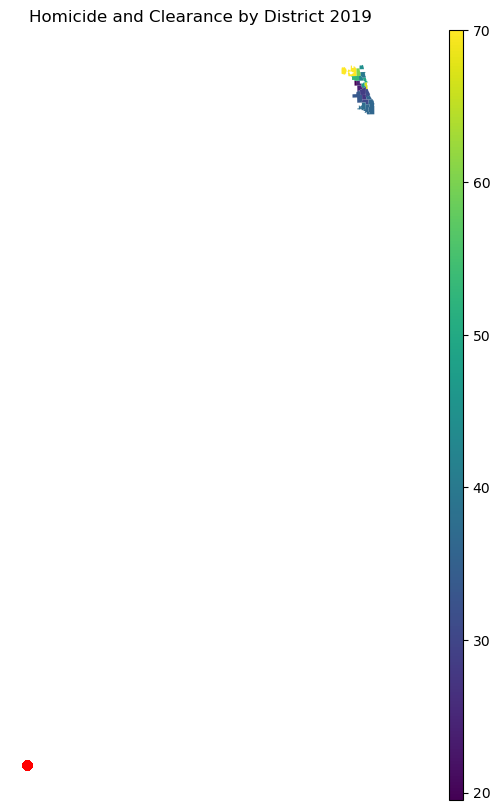

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
ax = hom_dist_2019.plot(ax=ax, column='dist_cr', legend=True, cax=cax)
ax = geo_2019.plot(ax=ax, color='red')
ax.axis('off')
ax.set_title('Homicide and Clearance by District 2019')

In [29]:
hom_beat_2019

,beat,beat_num,district,sector,geometry,index,homicide_count,cleared,tot_pop,white_nothisp,black_nothisp,tot_hisp,year,perc_white,perc_black,perc_hisp
0,1,1713.0,17,1,"POLYGON ((1155178.845 1934389.237, 1155178.940...",145,1,1,12221.0,4253.0,704.0,5205.0,2021,34.80,5.76,42.59
1,3,735.0,07,3,"POLYGON ((1166869.281 1858961.703, 1166872.950...",67,2,0,5314.0,32.0,4025.0,1134.0,2021,0.60,75.74,21.34
2,2,1722.0,17,2,"POLYGON ((1148861.936 1931598.865, 1148864.830...",146,1,1,13838.0,6610.0,555.0,4524.0,2021,47.77,4.01,32.69
3,2,1923.0,19,2,"POLYGON ((1170202.914 1926773.656, 1170205.660...",155,1,1,10361.0,7465.0,759.0,1072.0,2021,72.05,7.33,10.35
4,2,1724.0,17,2,"POLYGON ((1157272.498 1930400.978, 1157275.060...",147,1,0,15911.0,6529.0,602.0,6878.0,2021,41.03,3.78,43.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,1,314.0,03,1,"POLYGON ((1187301.942 1865532.830, 1187399.600...",16,1,1,5934.0,843.0,4102.0,332.0,2021,14.21,69.13,5.59
173,2,825.0,08,2,"POLYGON ((1162653.112 1865493.004, 1162670.972...",75,4,1,8738.0,120.0,4164.0,4300.0,2021,1.37,47.65,49.21
174,1,313.0,03,1,"POLYGON ((1181918.041 1865379.952, 1182043.210...",15,1,0,5608.0,278.0,4843.0,163.0,2021,4.96,86.36,2.91
175,2,823.0,08,2,"POLYGON ((1158738.406 1864742.269, 1158739.870...",73,4,1,21484.0,911.0,2737.0,17516.0,2021,4.24,12.74,81.53
